# Monte Carlo Default Simulation

We aim to estimate the expected loss up to time T:

$$E[L_T] = E\left[\sum_{i=1}^{N} \ell_i \cdot 1\{T_i \leq T\}\right]$$

Where:

- $\ell_i$ represents the loss amount from default $i$
- $T_i$ represents the default time for firm $i$
- $1\{T_i \leq T\}$ is the indicator function for defaults occurring before time $T$

## Model Components

### Firm Intensity Process
Each firm's default intensity is modeled as:

$$\lambda_t^i = X_i + \sum_{j=1}^{J} w_{ij} Y_t^j$$

Where:
- $X_i$ is the idiosyncratic component for firm $i$
- $Y_t^j$ is the sectoral intensity component
- $w_{ij}$ are loading factors representing sensitivity to sectoral factors

### Sectoral Intensity Dynamics with Contagion
Each sector follows a process with mean reversion, volatility, and contagion effects:

$$dY_t^j = \kappa_j(\theta_j - Y_t^j)dt + \sqrt{Y_t^j}\sum_{k=1}^{J}\sigma_{jk}dW_t^k + \sum_{k=1}^{J}\delta_{jk}dL_t^k$$

Where:
- $\kappa_j$ is the mean reversion speed
- $\theta_j$ is the long-term mean level
- $\sigma_{jk}$ are volatility parameters
- $W_t^k$ are standard Brownian motions
- $\delta_{jk}$ are contagion coefficients
- $L_t^k$ are loss processes for each sector


## In this notebook we attempt to use the Jump Approximation Methods as discussed in *Reducing Bias in Event Time Simulations via Measure Changes (Giesecke, Shkolnik (2018))*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go

RNG = np.random.default_rng(42)

In [2]:
def draw_params(N=100, J=5):

    X = RNG.uniform(0.01, 0.05, size=N)                      # idio intensities

    w0 = RNG.uniform(0,1,(N,J))
    W = w0 / w0.sum(axis=1, keepdims=True)                   # exposures

    ell = np.ones(N)                                         # LGD
    
    kappa = RNG.uniform(0.5,1.5,size=J)
    theta = RNG.uniform(0.05,0.25,size=J)
    
    sigma = np.zeros((J,J))
    for j in range(J):
        s = RNG.uniform(0.1,0.2)
        sigma[j,j] = min(s, np.sqrt(2*kappa[j]*theta[j])) # enforce feller condn 
    
    sigma[sigma==0] = 0.05                                   # off-diag
    
    delta = RNG.uniform(0,0.1,(J,J))
    
    # Brownian corr matrix
    rho = 0.3
    Corr = np.eye(J)*1 + (1-np.eye(J))*rho
    
    return dict(N=N, J=J, X=X, W=W, ell=ell,
                kappa=kappa, theta=theta, sigma=sigma, delta=delta,
                Corr=Corr)


In [3]:
params = draw_params()
print(params)

{'N': 100, 'J': 5, 'X': array([0.04095824, 0.02755514, 0.04434392, 0.03789472, 0.01376709,
       0.04902489, 0.04044559, 0.04144257, 0.01512455, 0.02801544,
       0.02483192, 0.0470706 , 0.0357546 , 0.04291046, 0.02773657,
       0.01908955, 0.03218339, 0.01255269, 0.04310525, 0.03526658,
       0.04032351, 0.02418104, 0.04882792, 0.04572484, 0.04113534,
       0.01778555, 0.02866884, 0.01175215, 0.01617158, 0.03732196,
       0.03979049, 0.04870039, 0.02303301, 0.02481839, 0.02878223,
       0.01757885, 0.01519686, 0.0290282 , 0.01907637, 0.03679256,
       0.02748608, 0.04330713, 0.0380106 , 0.02249467, 0.04329039,
       0.04219057, 0.02549914, 0.02153312, 0.03729982, 0.0155901 ,
       0.01799633, 0.01029449, 0.04147698, 0.03659403, 0.03820662,
       0.04122916, 0.02835663, 0.03274965, 0.01559188, 0.0145812 ,
       0.03673612, 0.02884385, 0.03260944, 0.04059995, 0.03538873,
       0.03214318, 0.03236829, 0.022158  , 0.01123271, 0.0274687 ,
       0.01858339, 0.02634115, 0.04413

In [4]:
import numpy as np

def simulate_plain_jam(params, T=1.0, dt_max=0.0001, seed=None):

    if seed is not None:
        np.random.seed(seed)

    N, J = params['N'], params['J']
    X = params['X']
    w = params['W']
    losses = params['ell']
    kappa = params['kappa']
    theta = params['theta']
    sigma = params['sigma']
    delta = params['delta']

    L_chol = np.linalg.cholesky(params['Corr'])
    
    # Initial sector intensities
    Y = theta.copy()

    # keep track of alive firms
    alive = np.arange(N)

    t = 0.0
    L_weight = 1.0
    total_loss = 0.0

    while t < T and alive.size > 0:
        # compute firmwise current intensities
        lambdas = X[alive] + (w[alive] @ Y)
        Lambda_q = lambdas.sum()
        if Lambda_q <= 0:
            break

        Delta = np.random.exponential(1.0 / Lambda_q)
        t_new = t + Delta
        if t_new > T:
            break

        # simulate sector intnesities sdes
        m = max(1, int(np.ceil(Delta / dt_max)))
        dt = Delta / m
        integral_p = 0.0
        t_sub = t
        for _ in range(m):
            # basic euler‐maruyama update
            z = np.random.randn(J)
            dW = L_chol @ (np.sqrt(dt) * z)
            for j in range(J):
                diffusion_term = np.sum(sigma[j, :] * np.sqrt(np.maximum(Y, 0.0)) * dW)
                dY = kappa[j] * (theta[j] - Y[j]) * dt + diffusion_term
                Y[j] = max(Y[j] + dY, 0.0)

            lambdas_sub = X[alive] + (w[alive] @ Y)
            integral_p += lambdas_sub.sum() * dt
            t_sub += dt

        # compute instentiies at t_new
        lambdas = X[alive] + (w[alive] @ Y)

        # choose defaulting firm
        probs = lambdas / Lambda_q
        probs = probs / probs.sum()  # normalise for np.random.choice to work stably
        i_rel = np.random.choice(len(alive), p=probs)
        firm = alive[i_rel]
        lambda_i = lambdas[i_rel]

        # compute the likelihood weight component
        area_Q = Lambda_q * Delta
        G = np.exp(area_Q - integral_p)
        L_weight *= G

        # now we apply the jumps
        # assume each firm has a primary sector k, takie the sector with highest loading
        k = np.argmax(w[firm])
        Y += delta[:, k]

        # record loss and remove firm
        total_loss += losses[firm]
        alive = np.delete(alive, i_rel)

        t = t_new

    return total_loss, L_weight


In [5]:
def simulate_mc(params, M=100):
    losses = np.zeros(M)
    weights = np.zeros(M)
    for i in range(M):
        loss, weight = simulate_plain_jam(params, seed=i)
        losses[i] = loss
        weights[i] = weight
    weighted_losses = losses * weights
    expected_loss = weighted_losses.mean()
    stddev = np.std(weighted_losses)
    return expected_loss, stddev



In [ ]:
simulate_mc(params, M=500)

In [ ]:
test_params = draw_params(N=50, J=3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from numba import jit, prange
from numba.core import types
from numba.typed import Dict
import pandas as pd

def draw_params(N=100, J=5, seed=42):
    """Draw model parameters as specified"""
    rng = np.random.default_rng(seed)
    
    X = rng.uniform(0.01, 0.05, size=N)                      # idio intensities

    w0 = rng.uniform(0, 1, (N, J))
    W = w0 / w0.sum(axis=1, keepdims=True)                   # exposures

    ell = np.ones(N)                                         # LGD
    
    kappa = rng.uniform(0.5, 1.5, size=J)
    theta = rng.uniform(0.05, 0.25, size=J)
    
    sigma = np.zeros((J, J))
    for j in range(J):
        s = rng.uniform(0.1, 0.2)
        sigma[j, j] = min(s, np.sqrt(2*kappa[j]*theta[j]))   # enforce feller condn 
    
    sigma[sigma==0] = 0.05                                   # off-diag
    
    delta = rng.uniform(0, 0.1, (J, J))
    
    # Brownian corr matrix
    rho = 0.4
    Corr = np.eye(J)*1 + (1-np.eye(J))*rho
    
    return dict(N=N, J=J, X=X, W=W, ell=ell,
                kappa=kappa, theta=theta, sigma=sigma, delta=delta,
                Corr=Corr)

@jit(nopython=True, cache=True)
def simulate_plainjam_path(
    X,                          # Idiosyncratic intensities [N]
    w,                          # Firm-sector weights [N, J]  
    losses,                     # Loss sizes per firm [N]
    kappa,                      # Mean-reversion speed [J]
    theta,                      # Long-term mean [J]
    sigma,                      # Volatility matrix [J, J]
    delta,                      # Contagion jumps [J, J]
    L_chol,                     # Cholesky of Brownian correlation [J, J]
    Y_init,                     # Initial sector state [J]
    T,                          # Time horizon
    dt_max,                     # Max substep size
    seed                        # Unique seed
):
    
    np.random.seed(seed)
    
    
    t = 0.0
    Y = Y_init.copy()
    N, J = w.shape
    alive = np.ones(N, dtype=np.bool_)
    total_loss = 0.0
    log_L = 0.0
    ell = 0  
    
    
    firm_sectors = np.zeros(N, dtype=np.int32)
    for i in range(N):
        max_weight = 0.0
        max_sector = 0
        for j in range(J):
            if w[i, j] > max_weight:
                max_weight = w[i, j]
                max_sector = j
        firm_sectors[i] = max_sector
    
    eps = 1e-12
    
    while t < T:
        n_alive = 0
        for i in range(N):
            if alive[i]:
                n_alive += 1
        
        if n_alive == 0:
            break
        
        alive_idx = np.zeros(n_alive, dtype=np.int32)
        idx_count = 0
        for i in range(N):
            if alive[i]:
                alive_idx[idx_count] = i
                idx_count += 1
        
        # Freeze Q-intensities at start of interval
        #TODO: OTher ways to ensure counting process is a step function unser Q measure?

        hQ = np.zeros(n_alive)
        for k in range(n_alive):
            i = alive_idx[k]
            h_val = X[i]
            for j in range(J):
                h_val += w[i, j] * Y[j]
            hQ[k] = max(h_val, 0.0)
        
        lambda_hat_ell = 0.0
        for k in range(n_alive):
            lambda_hat_ell += hQ[k]
        
        if lambda_hat_ell < eps:
            break
            
        u = np.random.uniform()
        eta = -np.log(u) / lambda_hat_ell
        S_ell = t + eta
        
        if S_ell > T:
            break
            
        m = int(np.ceil(eta / dt_max))
        dt = eta / m
        
        R_ell = 0.0
    
        hP_prev = np.zeros(n_alive)
        for k in range(n_alive):
            i = alive_idx[k]
            h_val = X[i]
            for j in range(J):
                h_val += w[i, j] * Y[j]
            hP_prev[k] = max(h_val, 0.0)
        
        for step in range(m):
            
            z = np.random.standard_normal(J) * np.sqrt(dt)
            dW = np.zeros(J)
            for i in range(J):
                for j in range(J):
                    dW[i] += L_chol[i, j] * z[j]
            
            # Update each sector using Euler-Maruyama under P
            for j in range(J):
                y = max(Y[j], 0.0)
                drift = kappa[j] * (theta[j] - y) * dt
                
                diffusion = 0.0
                for k in range(J):
                    diffusion += sigma[j, k] * dW[k]
                diffusion *= np.sqrt(y)
                
                Y[j] = max(Y[j] + drift + diffusion, 0.0)
            
            
            hP_curr = np.zeros(n_alive)
            for k in range(n_alive):
                i = alive_idx[k]
                h_val = X[i]
                for j in range(J):
                    h_val += w[i, j] * Y[j]
                hP_curr[k] = max(h_val, 0.0)
            
            # Trapezoidal rule integration
            for k in range(n_alive):
                R_ell += 0.5 * dt * (hP_curr[k] + hP_prev[k])
                hP_prev[k] = hP_curr[k]
        
        
        if lambda_hat_ell < eps:
            break
        
        
        probs = np.zeros(n_alive)
        for k in range(n_alive):
            probs[k] = hQ[k] / lambda_hat_ell
        
        cumprobs = np.zeros(n_alive)
        cumprobs[0] = probs[0]
        for k in range(1, n_alive):
            cumprobs[k] = cumprobs[k-1] + probs[k]
        
        u = np.random.uniform()
        i_rel = 0
        for k in range(n_alive):
            if u <= cumprobs[k]:
                i_rel = k
                break
        i_rel = min(i_rel, n_alive - 1)
        
        firm = alive_idx[i_rel]
        
        
        r_ell = R_ell
        if r_ell > eps:
            log_L += np.log(lambda_hat_ell / r_ell) + R_ell - lambda_hat_ell * eta
        
        # Apply contagion jump
        sector_k = firm_sectors[firm]
        for j in range(J):
            Y[j] = max(Y[j] + delta[j, sector_k], 0.0)

        total_loss += losses[firm]
        alive[firm] = False
        t = S_ell
        ell += 1
    
    # Compute likelihood weight
    MAX_LOG = 100.0
    log_L = max(min(log_L, MAX_LOG), -MAX_LOG)
    weight = np.exp(log_L)
    
    return total_loss, weight

@jit(nopython=True, parallel=True, cache=True)
def run_simulation(
    X, w, losses, kappa, theta, sigma, delta, L_chol, Y_init,
    n_paths, T, dt_max, base_seed
):
    results_loss = np.zeros(n_paths)
    results_weight = np.zeros(n_paths)
    
    for i in prange(n_paths):
        seed = base_seed + i
        loss, weight = simulate_plainjam_path(
            X, w, losses, kappa, theta, sigma, delta, L_chol, Y_init,
            T, dt_max, seed
        )
        results_loss[i] = loss
        results_weight[i] = weight
    
    return results_loss, results_weight

class MonteCarloSimulator:
    
    def __init__(self, params):
        self.params = params
        self.N = params['N']
        self.J = params['J']
        
        self.X = np.asarray(params['X'], dtype=np.float64)
        self.w = np.asarray(params['W'], dtype=np.float64)
        self.losses = np.asarray(params['ell'], dtype=np.float64)
        self.kappa = np.asarray(params['kappa'], dtype=np.float64)
        self.theta = np.asarray(params['theta'], dtype=np.float64)
        self.sigma = np.asarray(params['sigma'], dtype=np.float64)
        self.delta = np.asarray(params['delta'], dtype=np.float64)
        
        
        try:
            self.L_chol = cholesky(params['Corr'], lower=True).astype(np.float64)
        except np.linalg.LinAlgError:
            # If Cholesky fails, use identity
            print("Warning: Correlation matrix not positive definite, using identity")
            self.L_chol = np.eye(self.J, dtype=np.float64)
    
    def run_simulation(self, n_paths=1000, T=5.0, dt_max=0.01, base_seed=1000):

        # Start at long-term mean
        Y_init = self.theta.copy()
        
        print(f"Running {n_paths} simulations...")
        
        
        losses, weights = run_simulation(
            self.X, self.w, self.losses, self.kappa, self.theta, 
            self.sigma, self.delta, self.L_chol, Y_init,
            n_paths, T, dt_max, base_seed
        )
        
        # Compute weighted statistics
        total_weight = np.sum(weights)
        if total_weight > 0:
            expected_loss = np.sum(losses * weights) / total_weight
            
            variance = np.sum(weights * (losses - expected_loss)**2) / total_weight
            std_error = np.sqrt(variance / n_paths)
            effective_sample_size = total_weight**2 / np.sum(weights**2)
        else:
            expected_loss = np.mean(losses)
            std_error = np.std(losses) / np.sqrt(n_paths)
            variance = np.var(losses)
            effective_sample_size = n_paths
        
        return {
            'expected_loss': expected_loss,
            'std_error': std_error,
            'variance': variance,
            'losses': losses,
            'weights': weights,
            'n_paths': n_paths,
            'effective_sample_size': effective_sample_size
        }
    
    def plot_results(self, results):
        """Plot simulation results"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        
        losses = results['losses']
        weights = results['weights']
        
        # Loss distribution
        ax1.hist(losses, bins=50, alpha=0.7, density=True)
        ax1.axvline(results['expected_loss'], color='red', linestyle='--', 
                   label=f'E[L] = {results["expected_loss"]:.3f}')
        ax1.set_xlabel('Total Loss')
        ax1.set_ylabel('Density')
        ax1.set_title('Loss Distribution')
        ax1.legend()
        
        # # Weight distribution (log scale)
        # positive_weights = weights[weights > 0]
        # if len(positive_weights) > 0:
        #     ax2.hist(positive_weights, bins=50, alpha=0.7)
        #     ax2.set_xlabel('Importance Weight')
        #     ax2.set_ylabel('Frequency')
        #     ax2.set_title('Weight Distribution')
        #     ax2.set_yscale('log')
        
        # # Loss vs Weight scatter
        # positive_mask = weights > 0
        # if np.any(positive_mask):
        #     ax3.scatter(losses[positive_mask], weights[positive_mask], alpha=0.6, s=1)
        #     ax3.set_xlabel('Total Loss')
        #     ax3.set_ylabel('Weight')
        #     ax3.set_title('Loss vs Weight')
        #     ax3.set_yscale('log')
        
        # # Convergence plot
        # cumulative_weighted_loss = np.cumsum(losses * weights)
        # cumulative_weights = np.cumsum(weights)
        
        # # Avoid division by zero
        # valid_idx = cumulative_weights > 0
        # if np.any(valid_idx):
        #     running_mean = np.zeros_like(cumulative_weighted_loss)
        #     running_mean[valid_idx] = cumulative_weighted_loss[valid_idx] / cumulative_weights[valid_idx]
            
        #     ax4.plot(running_mean)
        #     ax4.axhline(results['expected_loss'], color='red', linestyle='--')
        #     ax4.set_xlabel('Simulation Number')
        #     ax4.set_ylabel('Running Expected Loss')
        #     ax4.set_title('Convergence')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nSimulation Results:")
        print(f"Expected Loss: {results['expected_loss']:.6f}")
        print(f"Standard Error: {results['std_error']:.6f}")
        print(f"95% CI: [{results['expected_loss'] - 1.96*results['std_error']:.6f}, "
              f"{results['expected_loss'] + 1.96*results['std_error']:.6f}]")
        print(f"Effective Sample Size: {results['effective_sample_size']:.1f}")
        
        valid_weights = weights[weights > 0]
        if len(valid_weights) > 0:
            print(f"Weight Statistics: min={np.min(valid_weights):.2e}, max={np.max(valid_weights):.2e}, "
                  f"mean={np.mean(valid_weights):.2e}")
        print(f"Zero weights: {np.sum(weights == 0)} / {len(weights)}")

    def plot_sample_intensity_paths(self, T=1.0, dt_max=0.001, n_paths=5, seed=42):
        np.random.seed(seed)
        
        fig = go.Figure()
        N, J = self.w.shape

        for path in range(n_paths):
            times = [0.0]
            sum_hQ_list = []
            sum_hP_list = []
            jump_times = []

            Y = self.theta.copy()
            t = 0.0
            alive = np.ones(N, dtype=bool)

            while t < T:
                alive_idx = np.where(alive)[0]
                if len(alive_idx) == 0:
                    break

                # Q-intensity (frozen)
                hQ = np.array([max(self.X[i] + np.dot(self.w[i], Y), 0.0) for i in alive_idx])
                λ_hat = np.sum(hQ)
                if λ_hat < 1e-12:
                    break

                η = -np.log(np.random.rand()) / λ_hat
                S = t + η
                if S > T:
                    break

                m = int(np.ceil(η / dt_max))
                dt = η / m
                times_segment = np.linspace(t, S, m + 1)[1:]

                sum_hQ_list.extend([λ_hat] * m)

                hP_vals = []
                for _ in range(m):
                    dW = self.L_chol @ np.random.randn(J) * np.sqrt(dt)
                    for j in range(J):
                        y = max(Y[j], 0.0)
                        drift = self.kappa[j] * (self.theta[j] - y) * dt
                        diffusion = np.sqrt(y) * np.sum(self.sigma[j, :] * dW)
                        Y[j] = max(Y[j] + drift + diffusion, 0.0)
                    λ_p = np.sum([max(self.X[i] + np.dot(self.w[i], Y), 0.0) for i in alive_idx])
                    hP_vals.append(λ_p)

                times.extend(times_segment)
                sum_hP_list.extend(hP_vals)
                jump_times.append(S)

                probs = hQ / λ_hat
                i_rel = np.searchsorted(np.cumsum(probs), np.random.rand())
                firm = alive_idx[min(i_rel, len(alive_idx) - 1)]
                sector_k = np.argmax(self.w[firm])
                Y += self.delta[:, sector_k]
                Y = np.maximum(Y, 0.0)
                alive[firm] = False
                t = S

            times = np.array(times[:len(sum_hP_list)])  # ensure matching

            fig.add_trace(go.Scatter(
                x=times, y=sum_hP_list,
                mode='lines',
                name=f'P-intensity {path+1}',
                line=dict(dash='dot'),
                opacity=0.6
            ))

            fig.add_trace(go.Scatter(
                x=times, y=sum_hQ_list,
                mode='lines',
                name=f'Q-intensity {path+1}',
                line=dict(width=2),
                opacity=0.8
            ))

            fig.add_trace(go.Scatter(
                x=jump_times,
                y=[max(sum_hP_list[min(len(sum_hP_list)-1, int(t/T * len(sum_hP_list)))], 1e-2) for t in jump_times],
                mode='markers',
                name=f'Jumps {path+1}',
                marker=dict(symbol='x', size=8),
                showlegend=False
            ))

        fig.update_layout(
            title='Q vs P Intensity Sample Paths (Plain JAM)',
            xaxis_title='Time',
            yaxis_title='Total Intensity',
            hovermode='closest',
            template='plotly_white',
            legend=dict(itemsizing='constant')
        )

        fig.show()

Running 50000 simulations with Numba JIT...


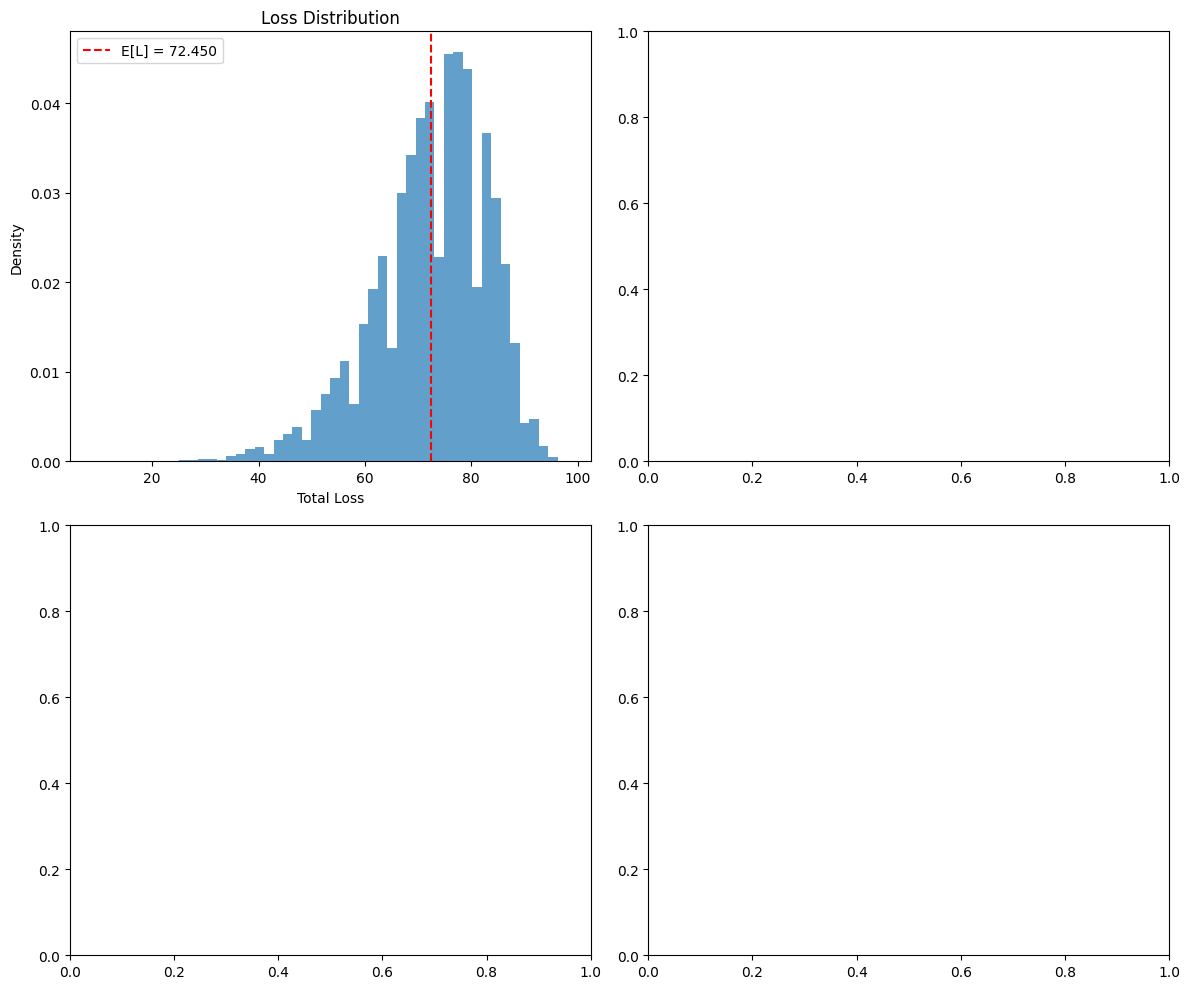


Simulation Results:
Expected Loss: 72.449668
Standard Error: 0.047351
95% CI: [72.356860, 72.542477]
Effective Sample Size: 49976.4
Weight Statistics: min=1.18e+11, max=2.69e+43, mean=2.69e+43
Zero weights: 0 / 50000


In [7]:
params = draw_params(N=100, J=3, seed=42)
simulator = MonteCarloSimulator(params)

results = simulator.run_simulation(n_paths=50000, T=1.0, dt_max=0.001, base_seed=1000)
simulator.plot_results(results)
simulator.plot_sample_intensity_paths(T=1.0, dt_max=0.0001, n_paths=5, seed=1000)